In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

# Defining the working directories

train_path = r'/content/drive/My Drive/AML/cassava-leaf-disease-classification/train_images'


In [ ]:
# Importing Train Data
import sys
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv(r'/content/drive/My Drive/AML/cassava-leaf-disease-classification/train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [ ]:
# Importing the json file with labels

f = open(r'/content/drive/My Drive/AML/cassava-leaf-disease-classification/label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset

data['class_name'] = data.label.map(real_labels)

# Splitting the data

from sklearn.model_selection import train_test_split

train,val = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

# Importing the data using ImageDataGenerator

IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


In [ ]:
# MODEL CREATION 

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                             weights = 'imagenet',
                             drop_connect_rate=0.6))
    #for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
    #    layer.trainable = False
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 15, 15, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_____________________________________

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


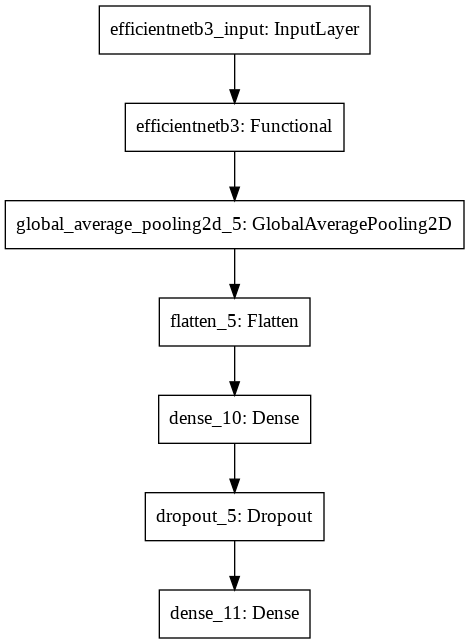

In [ ]:
keras.utils.plot_model(leaf_model)

In [ ]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [ ]:
# FITTING THE MODEL

def Model_fit():
    
    #leaf_model = None
    
    leaf_model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    leaf_model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'
    
    # Stop training when the val_loss has stopped decreasing for 3 epochs.
    es = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint(r'/content/drive/My Drive/AML/Cassava_best_model.h5',
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    
    history = leaf_model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[es, checkpoint_cb, reduce_lr])
    
    leaf_model.save(r'/content/drive/My Drive/AML' + '.h5')  
    
    return history

In [ ]:
results = Model_fit()

Epoch 1/50
1355/1355 [==============================] - 3186s 2s/step - loss: 0.8358 - categorical_accuracy: 0.7086 - val_loss: 0.4939 - val_categorical_accuracy: 0.8347
Epoch 2/50
1355/1355 [==============================] - 1492s 1s/step - loss: 0.5610 - categorical_accuracy: 0.8120 - val_loss: 0.5712 - val_categorical_accuracy: 0.8319
Epoch 3/50
1355/1355 [==============================] - 1438s 1s/step - loss: 0.5151 - categorical_accuracy: 0.8346 - val_loss: 0.4333 - val_categorical_accuracy: 0.8535
Epoch 4/50
1355/1355 [==============================] - 1403s 1s/step - loss: 0.4891 - categorical_accuracy: 0.8362 - val_loss: 0.4981 - val_categorical_accuracy: 0.8469
Epoch 5/50
1355/1355 [==============================] - 1444s 1s/step - loss: 0.4744 - categorical_accuracy: 0.8446 - val_loss: 0.4211 - val_categorical_accuracy: 0.8460
Epoch 6/50
1355/1355 [==============================] - 1484s 1s/step - loss: 0.4552 - categorical_accuracy: 0.8537 - val_loss: 0.4383 - val_categoric

In [ ]:
print('Train-Acc: ', max(results.history['categorical_accuracy']))
print('Val_-Acc: ', max(results.history['val_categorical_accuracy']))

Train-Acc:  0.9034560918807983
Val_-Acc:  0.9004694819450378


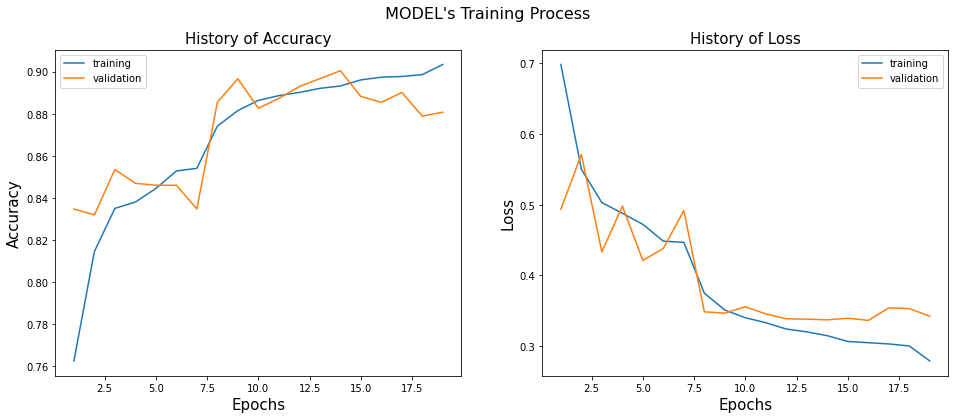

In [ ]:
# PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (16, 6))
    fig.suptitle(" MODEL's Training Process ", fontsize=16)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['categorical_accuracy'],results.history['val_categorical_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
# EVALUATING THE MODEL

import keras

final_model = keras.models.load_model(r'/content/drive/My Drive/AML/Cassava_best_model.h5')

In [ ]:
TEST_DIR = r'/content/drive/My Drive/AML/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
datagen = ImageDataGenerator(horizontal_flip=True)


def pred(images):
    for image in test_images:
        img = Image.open(TEST_DIR + image)
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=1)
        yhats = final_model.predict(it, steps=1, verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(test_images)

In [ ]:
# Creating the CSV for final submission

sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
sub.to_csv('submission.csv', index = False)

,image_id,label
0,2216849948.jpg,4
